In [1]:
import os
import sys
import pandas
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from PIL import Image
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
from collections import Counter
import random
torch.random.manual_seed(535)

In [2]:
import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import AsyncHyperBandScheduler, PopulationBasedTraining

In [3]:
default_data_dir = "/s/bach/b/class/cs535/cs535a"
DATA_DIR = os.getenv('TP_DATADIR',default_data_dir)

print("Using {} for Data Directory".format(DATA_DIR))

covid_dir = os.path.join(DATA_DIR,"covid-chest-xray")
covid2_dir = os.path.join(DATA_DIR,"covid-xray-2")
covid_metadata = os.path.join(covid_dir,"metadata.csv")


covid_df = pandas.read_csv(covid_metadata)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Using /s/bach/b/class/cs535/cs535a for Data Directory
cpu


In [4]:
class CovidDataset(Dataset):
    classCount = 2
    def __init__(self, root_dir, image_df, transform=None, oversample=False,oversample_transform=None,channels=3):
        xrays = set(image_df[image_df['modality'] == 'X-ray']['filename'].values)
        files = set(os.listdir(root_dir))
        self.filenames = list(files.intersection(xrays))
        self.channel_type = 'L' if channels == 1 else 'RGB'
        
        self.orig_len = len(self.filenames)
        self.root_dir = root_dir
        self.oversample = oversample
        self.oversample_transform = oversample_transform
        self.oversamples = []
        self.transform = transform
        self.classVec = torch.zeros(2)
        self.lookup = {}
        filenames = image_df[['filename','finding']]
        
        for idx,row in filenames.iterrows():
            if row['filename'] not in self.filenames:
                continue
            self.lookup[row['filename']] = 0 if 'covid' in row['finding'].lower() else 1
            
        if oversample:
            self.choose_oversamples()
            
    def choose_oversamples(self):
        oversamples = []
        class_sizes = Counter(self.lookup.values())
        mc = class_sizes.most_common(1)[0]
        for classKey in class_sizes.keys():
            if classKey == mc[0]: # most common class
                continue
            num_short = mc[1] - class_sizes[classKey]
            target = [k for k,v in self.lookup.items() if v == classKey]
            for i in range(num_short):
                oversamples.append(random.choice(target))
                
        self.oversamples = oversamples
                
    def __len__(self):
        return len(self.filenames) + len(self.oversamples)

    def __getitem__(self, idx):
        if idx < self.orig_len:
            filename = self.filenames[idx]
        else:
            ov_index = idx - self.orig_len
            filename = self.oversamples[ov_index]
            
        img_name = os.path.join(self.root_dir, filename)
        #classVec = copy.deepcopy(self.classVec)
        classIndex = self.lookup[filename]
        #classVec[index] = 1

        # need "multi" one hot for BCE
        image = Image.open(img_name)
        
        if image.mode != self.channel_type:
            image = image.convert(self.channel_type)
        
        if self.oversample_transform:
            image = self.oversample_transform(image)

        if self.transform:
            image = self.transform(image)

        
        return image, classIndex

class CovidDataset2(Dataset):
    classCount = 2
    def __init__(self, root_dir, transform=None,channels=3):
        covid_files = set(os.listdir(f"{root_dir}/covid"))
        noncovid_files = set(os.listdir(f"{root_dir}/noncovid"))
        self.filenames = [f'{root_dir}/covid/{x}' for x in covid_files] + [f'{root_dir}/noncovid/{x}' for x in noncovid_files]
        self.channel_type = 'L' if channels == 1 else 'RGB'
        
        self.root_dir = root_dir
        self.transform = transform
        self.classVec = torch.zeros(2)
        self.lookup = {}
        
        for fn in self.filenames:
            self.lookup[fn] = 1 if 'noncovid' in fn else 0
            
                
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        classIndex = self.lookup[filename]

        image = Image.open(filename)
        
        if image.mode != self.channel_type:
            image = image.convert(self.channel_type)
        
        if self.transform:
            image = self.transform(image)

        
        return image, classIndex    

In [5]:
def init_dataloaders(config):
    # Data augmentation and normalization for training
    # Just normalization for validation
    input_size = 224
    mode = config.get('mode','standalone')
    if mode == 'standalone':
        gs_num = 3
    elif mode == 'xray':
        gs_num = 1
        
    train_transform = [
            transforms.Grayscale(gs_num),
            transforms.Resize([input_size,input_size]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            
        ]
    oversample_transform = [
        transforms.Grayscale(gs_num),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4)])
    ]
    
    test_transform = [
        transforms.Grayscale(gs_num),
        transforms.Resize([input_size,input_size]),
        transforms.ToTensor(),
        
    ]
    
    
    
    if mode == 'standalone':
        oversample_transform.append(transforms.RandomRotation(10))
        train_transform.append(transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]))
        test_transform.append(transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]))
    elif mode == 'xray':
        train_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
        test_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
       
    
    data_transforms = {
        'train': transforms.Compose(train_transform),
        'oversample': transforms.Compose(oversample_transform),
        'test': transforms.Compose(test_transform)
    }

    image_dir = os.path.join(covid_dir,'images')
    test_dir = os.path.join(covid_dir,'test')

    covid_img_dataset = CovidDataset(image_dir,covid_df,data_transforms['train'],oversample=True,oversample_transform=data_transforms['oversample'])
    test_img_dataset = CovidDataset(test_dir,covid_df,data_transforms['test'])
    test2_img_dataset = CovidDataset2(covid2_dir,data_transforms['test'])

    train_set = covid_img_dataset

    image_datasets = {'train':train_set,'val':test_img_dataset,'test':test_img_dataset,'test2':test2_img_dataset}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val','test','test2']}
    
    global dataset_sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test','test2']}

    

    print(f"Dataset sizes: {dataset_sizes}")
    return dataloaders

Dataset sizes: {'train': 368, 'val': 45, 'test': 45, 'test2': 158}


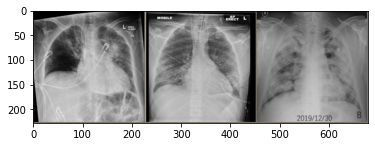

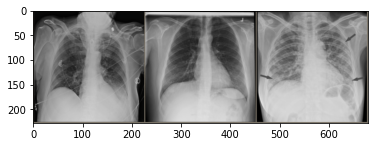

In [39]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    
def dataloader_top(dataloaders,name='train'):
    # Get a batch of training data
    inputs, classes = next(iter(dataloaders[name]))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[0:3])

    imshow(out)

dl = init_dataloaders({'mode':'standalone'})
dataloader_top(dl,'test')
dataloader_top(dl,'test2')

In [7]:
def evaluate_model(model,dataloaders,dataset='test'):
    was_training = model.training
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[dataset]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            
            for j in range(inputs.size()[0]):
                correct_index = labels[j]
                pred_index = preds[j]
                if correct_index == pred_index:
                    correct += 1
                total += 1
                
        model.train(mode=was_training)
        
    return correct / total

def train_one_epoch(model,criterion,optimizer,scheduler,dataloader):
    model.train()  # Set model to training mode

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

    # statistics
    scheduler.step()
    return model

    

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()
    train_loss = []
    val_loss = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    loss_df = pandas.DataFrame({'epoch': range(len(train_loss)),'train_loss':train_loss,'val_loss':val_loss})

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_df

In [8]:
def init_model(config=dict()):
    model_ft = config.get("model",models.resnext50_32x4d(pretrained=True))
    if model_ft == 'xray':
        model_ft = Net()
    if 'statedict' in config:
        model_ft.load_state_dict(config['statedict'])
    last_name = config.get("last-layer-name","fc")
    final_layer = eval(f"model_ft.{last_name}")
    num_ftrs = eval(f"model_ft.{last_name}.in_features")
    
    final_layer = nn.Linear(num_ftrs, CovidDataset.classCount)

    model_ft = model_ft.to(device)
    crit = config.get('criterion','CELoss')
    if crit == 'CELoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise Exception("Unsupported criterion")

    # Observe that all parameters are being optimized
    optimizer = config.get('optim','SGD')
    if optimizer == 'SGD':
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=config.get('lr',0.001), momentum=config.get('momentum',0.9))
    elif optimizer == 'Adam':
        optimizer_ft = optim.Adam(model_ft.parameters(), lr=config.get('lr',0.001))
    else:
        raise Exception("unsupported optimizer {}".format(optimizer))

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=config.get('lr_step_size',7), gamma=config.get('lr_gamma',0.1))
    return model_ft, criterion, optimizer_ft, exp_lr_scheduler
    

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # in_channels = 1 because they are greyscale images
        # out_channels = 6 means, we're using 6, 5*5 filters/kernals, thus 6 outputs will be there
        # output of the previous layer is the input to the next layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        # when moving from the convolutional layer to fully connected layers, inputs should be flattened
        self.fc1 = nn.Linear(in_features=12 * 53 * 53, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        # out_features = 15 because we have 15 class labels
        self.out = nn.Linear(in_features=60, out_features=15)

    def forward(self, t):
        # (1) input layer
        t = t  # here we show this for clarity

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 53 * 53)  # change the shape accordingly
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        # softmax returns a probability of predictions for each class,
        # however, we don't need this, if we're using cross_entropy during training
        # t = F.softmax(t, dim=1)

        return t    

In [10]:
class CovidTrainable(tune.Trainable):
    def _setup(self,config):
        self.device = config.get('device',device)
        self.dataloaders = config.get('dataloaders')
        if self.dataloaders == 'xray':
            self.dataloaders = init_dataloaders({'mode': 'xray'})
        else:
            self.dataloaders = init_dataloaders({'mode': 'standalone'})
        self.model, self.criterion, self.optimizer, self.scheduler = init_model(config)
    
    def _train(self):
        train_one_epoch(self.model,self.criterion,self.optimizer,self.scheduler,self.dataloaders['train'])
        return {'accuracy': evaluate_model(self.model,self.dataloaders,'val')}
    
    def _save(self,checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir,"model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path
    
    def _restore(self,checkpiont_path):
        self.model.load_state_dict(torch.load(checkpoint_path))

def sample_config(config):
    return {k: v() for k,v in config.items()}

def tuner(max_t=5):
    checkpoint_dir = os.path.join(DATA_DIR,'checkpoints')
  
    config = {"optim":lambda: random.choice(['SGD','Adam']),
              "lr": lambda: np.random.uniform(0.0001,0.02), 
              'lr_step_size': lambda: tune.randint(1,20),
              'lr_gamma': lambda: np.random.uniform(0,1),
              'momentum': lambda: np.random.uniform(0,1),
              'device': lambda: 'cpu',
              'dataloaders': lambda: 'standalone'
            

    }
    sched = PopulationBasedTraining(time_attr="training_iteration",metric="accuracy",mode='max', hyperparam_mutations=config,perturbation_interval=5)

    first_tune = tune.run(CovidTrainable,name="COVID Classifier",scheduler=sched,stop={"accuracy": 0.99,"training_iteration": max_t},
           num_samples=5 if max_t < 5 else 150,config=sample_config(config),raise_on_failed_trial=False, local_dir=checkpoint_dir,max_failures=0)
    ft_best = first_tune.get_best_config(metric="accuracy")
    print(f"Best config is: { ft_best}")
  
    return ft_best

xray_model_path = os.path.join(DATA_DIR,'allison_workarea','cs535-term-project','sgd_60_0.1_30_60_epoch_model.pth')
xray_model_dict = torch.load(xray_model_path)
xray_model = Net()
renamed_model_dict = {k.replace('module.',''): v for k,v in xray_model_dict.items()}
xray_model.load_state_dict(renamed_model_dict)


def xray_tuner(max_t=5):
    checkpoint_dir = os.path.join(DATA_DIR,'checkpoints')
  
  
    config = {"optim":lambda: random.choice(['SGD','Adam']),
              "lr": lambda: np.random.uniform(0.0001,0.02), 
              'lr_step_size': lambda: tune.randint(1,20),
              'lr_gamma': lambda: np.random.uniform(0,1),
              'momentum': lambda: np.random.uniform(0,1),
              'device': lambda: 'cpu',
              'model': lambda: 'xray',
              'statedict': lambda: renamed_model_dict,
              'last-layer-name': lambda: 'out',
              'dataloaders': lambda: 'xray'
            

    }
    sched = PopulationBasedTraining(time_attr="training_iteration",metric="accuracy",mode='max', hyperparam_mutations=config,perturbation_interval=5)

    first_tune = tune.run(CovidTrainable,name="COVID Classifier",scheduler=sched,stop={"accuracy": 0.99,"training_iteration": max_t},
           num_samples=5 if max_t < 5 else 150,config=sample_config(config),raise_on_failed_trial=False, local_dir=checkpoint_dir,max_failures=0,global_checkpoint_period=np.Inf)
    ft_best = first_tune.get_best_config(metric="accuracy")
    print(f"Best config is: { ft_best}")
  
    return ft_best

# Standalone Covid
## Non-hyper parameterized finetuning of randomized ResNext model

In [11]:
sa_dataloaders = init_dataloaders({'mode':'standalone'})

Dataset sizes: {'train': 368, 'val': 45, 'test': 45, 'test2': 158}


In [12]:
# Fine Tune non pretrained ResNext
no_pt_model, criterion, optimizer_ft, exp_lr_scheduler = init_model({'model': models.resnext50_32x4d(pretrained=False)})

no_pt_model,no_pt_loss = train_model(no_pt_model, criterion, optimizer_ft, exp_lr_scheduler, sa_dataloaders, num_epochs=80)

Epoch 0/79
----------
train Loss: 1.8677 Acc: 0.5163
val Loss: 3.7388 Acc: 0.3111

Epoch 1/79
----------
train Loss: 1.6269 Acc: 0.4538
val Loss: 0.7433 Acc: 0.5111

Epoch 2/79
----------
train Loss: 1.2388 Acc: 0.5516
val Loss: 0.5710 Acc: 0.7778

Epoch 3/79
----------
train Loss: 1.8626 Acc: 0.4837
val Loss: 2.5385 Acc: 0.1556

Epoch 4/79
----------
train Loss: 1.7104 Acc: 0.5190
val Loss: 1.4058 Acc: 0.1556

Epoch 5/79
----------
train Loss: 1.0051 Acc: 0.4538
val Loss: 0.8012 Acc: 0.8444

Epoch 6/79
----------
train Loss: 1.1524 Acc: 0.5136
val Loss: 0.5017 Acc: 0.8444

Epoch 7/79
----------
train Loss: 0.7216 Acc: 0.5217
val Loss: 0.6549 Acc: 0.7333

Epoch 8/79
----------
train Loss: 0.7186 Acc: 0.5516
val Loss: 0.6735 Acc: 0.7333

Epoch 9/79
----------
train Loss: 0.7115 Acc: 0.5543
val Loss: 0.8497 Acc: 0.5556

Epoch 10/79
----------
train Loss: 0.6968 Acc: 0.6005
val Loss: 0.6605 Acc: 0.8444

Epoch 11/79
----------
train Loss: 0.7226 Acc: 0.5245
val Loss: 0.6778 Acc: 0.7333

Ep

In [13]:
no_pt_model_results = {'test1': evaluate_model(no_pt_model,sa_dataloaders,'test'), 'test2': evaluate_model(no_pt_model,sa_dataloaders,'test2')}
print(no_pt_model_results)

{'test1': 0.8444444444444444, 'test2': 0.5}


## Non-hyper parameterized finetuning of pretrained ResNext model

In [ ]:
pt_model, criterion, optimizer_ft, exp_lr_scheduler = init_model()

pt_model,pt_model_loss = train_model(pt_model, criterion, optimizer_ft, exp_lr_scheduler, sa_dataloaders, num_epochs=80)

Epoch 0/79
----------
train Loss: 1.6110 Acc: 0.5245
val Loss: 0.5663 Acc: 0.8444

Epoch 1/79
----------
train Loss: 0.6727 Acc: 0.6603
val Loss: 0.2974 Acc: 0.8889

Epoch 2/79
----------
train Loss: 0.5837 Acc: 0.7147
val Loss: 0.3561 Acc: 0.8889

Epoch 3/79
----------
train Loss: 0.4944 Acc: 0.7853
val Loss: 0.3749 Acc: 0.8444

Epoch 4/79
----------
train Loss: 0.5370 Acc: 0.7717
val Loss: 0.2843 Acc: 0.9111

Epoch 5/79
----------
train Loss: 0.4390 Acc: 0.8071
val Loss: 0.4482 Acc: 0.8222

Epoch 6/79
----------
train Loss: 0.5635 Acc: 0.7962
val Loss: 0.5934 Acc: 0.8444

Epoch 7/79
----------
train Loss: 0.3908 Acc: 0.8560
val Loss: 0.2703 Acc: 0.8667

Epoch 8/79
----------
train Loss: 0.2773 Acc: 0.8804
val Loss: 0.2090 Acc: 0.9333

Epoch 9/79
----------
train Loss: 0.2090 Acc: 0.9239
val Loss: 0.2457 Acc: 0.9111

Epoch 10/79
----------
train Loss: 0.2435 Acc: 0.9158
val Loss: 0.1994 Acc: 0.9333

Epoch 11/79
----------
train Loss: 0.2596 Acc: 0.8832
val Loss: 0.1949 Acc: 0.9333

Ep

In [28]:
pt_model_results = {'test1': evaluate_model(pt_model,sa_dataloaders,'test'), 'test2': evaluate_model(pt_model,sa_dataloaders,'test2')}
print(pt_model_results)

{'test1': 0.9555555555555556, 'test2': 0.6582278481012658}


## Standalone Covid w/ HyperParameter Optimization Using RayTune

In [ ]:
ray.shutdown()
ray.init(address='129.82.44.79:3373', redis_password='5241590000000000')

In [ ]:
best_config = None
best_config = tuner(5)
print(best_config)

In [ ]:
sa_model_best, criterion_best, optimizer_best, scheduler_best = init_model(best_config)
sa_model_best,sa_best_loss = train_model(sa_model_best, criterion_best, optimizer_best, scheduler_best, sa_dataloaders, num_epochs=80)

In [29]:
sa_model_hyperparam_results = {'test1': evaluate_model(sa_model_best,sa_dataloaders,'test'), 'test2': evaluate_model(sa_model_best,sa_dataloaders,'test2')}
print(sa_model_hyperparam_results)

{'test1': 0.8444444444444444, 'test2': 0.5063291139240507}


## Non-Hyper Parameterized XRay Transfer Learning

In [ ]:
xray_model, criterion_best, optimizer_best, scheduler_best = init_model({'model':'xray','statedict':renamed_model_dict,'last-layer-name':'out'})
xray_dataloaders = init_dataloaders({'mode':'xray'})
xray_model,xray_loss = train_model(xray_model, criterion_best, optimizer_best, scheduler_best, xray_dataloaders, num_epochs=80)

In [30]:
xray_model_results = {'test1': evaluate_model(xray_model,xray_dataloaders,'test'), 'test2': evaluate_model(xray_model,xray_dataloaders,'test2')}
print(xray_model_results)


{'test1': 0.8222222222222222, 'test2': 0.5822784810126582}


## XRay Transfer Learning w/ HyperParameter Search

In [ ]:
xray_best = xray_tuner(5)

In [ ]:
xray_model_best, criterion_best, optimizer_best, scheduler_best = init_model(xray_best)
xray_dataloaders = init_dataloaders({'mode':'xray'})
xray_model_best,xray_best_loss = train_model(xray_model_best, criterion_best, optimizer_best, scheduler_best, xray_dataloaders, num_epochs=80)

In [31]:
xray_model_best_results = {'test1': evaluate_model(xray_model_best,xray_dataloaders,'test'), 'test2': evaluate_model(xray_model_best,xray_dataloaders,'test2')}
print(xray_model_best_results)


{'test1': 0.8666666666666667, 'test2': 0.569620253164557}


In [27]:
result_dfs = []
for data,label in zip((no_pt_model_results, pt_model_results, sa_model_hyperparam_results, xray_model_results, xray_model_best_results),
                      ('ResNext No Pretrain', 'ResNext Pretrain','ResNext Pretrain HyperParam','XRay Transfer Learn','XRay Transfer Learn HyperParam')):
    df = pandas.DataFrame(data,index=[0],columns=['label','test1','test2'])
    df['label'] = label
    result_dfs.append(df)
    
results = pandas.concat(result_dfs)
print(results)
    

                            label     test1     test2
0             ResNext No Pretrain  0.844444  0.500000
0                ResNext Pretrain  0.955556  0.658228
0     ResNext Pretrain HyperParam  0.844444  0.506329
0             XRay Transfer Learn  0.822222  0.582278
0  XRay Transfer Learn HyperParam  0.866667  0.569620


# Plots

In [ ]:
fig1 = no_pt_loss.plot(x='epoch', y=['train_loss','val_loss'],title="ResNext No Pretraining Loss").get_figure()
fig1.savefig('no_pt_loss.png')

fig2 = pt_model_loss.plot(x='epoch', y=['train_loss','val_loss'],title="Pretrained ResNext Loss").get_figure()
fig2.savefig('pt_loss.png')

fig3 = sa_best_loss.plot(x='epoch', y=['train_loss','val_loss'],title="Pretrained ResNext w/ HyperParam Loss").get_figure()
fig3.savefig('sa_best_loss.png')

fig4 = xray_loss.plot(x='epoch', y=['train_loss','val_loss'],title="NIH XRay Transfer Learning Loss").get_figure()
fig4.savefig('xray_loss.png')

fig5 = xray_best_loss.plot(x='epoch', y=['train_loss','val_loss'],title="NIH XRay Transfer Learning w/ HyperParam Loss").get_figure()
fig5.savefig('xray_best_loss.png')

